# 0.0 IMPORTS

In [1]:
from datetime import datetime
import warnings
import pickle
import json
import seaborn                          as sns
import pandas                           as pd
import numpy                            as np
import matplotlib.pyplot                as plt

## 0.1 Helper Functions

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:,.4f}".format

## 0.2 Loading Data

In [3]:
# Path
path_data = "../data/raw/"

# Files
file_train = "train.csv"

# CSV
df_train = pd.read_csv(path_data + file_train, low_memory=False)

# JSON
with open(path_data + 'county_id_to_name_map.json') as file:
    county_names = json.load(file)

# 1.0 DATA DESCRIPTIONS

In [4]:
df1_train =               df_train.copy()

## 1.1 Data Dimensions

In [5]:
print( 'Dataset: {}\n - Number of Rows: {} and Number of Columns: {}\n'.format('train', df1_train.shape[0], df1_train.shape[1]) )

Dataset: train
 - Number of Rows: 2018352 and Number of Columns: 9



## 1.2 Data Types and Memory Usage

In [6]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


## 1.3 Change Data Types

In [7]:
df1_train["datetime"] = pd.to_datetime(df1_train["datetime"])

df1_train["county"]         = df1_train["county"].astype("uint8")
df1_train["is_business"]    = df1_train["is_business"].astype("uint8")
df1_train["is_consumption"] = df1_train["is_consumption"].astype("uint8")
df1_train["product_type"]   = (
    df1_train["product_type"]
    .replace(
        {0: "combined", 1: "fixed", 2: "general_service", 3: "spot"}
    )
    .astype("category")
)

df1_train = df1_train.set_index("row_id").reset_index(drop=True)
df1_train = df1_train.drop(columns=["prediction_unit_id", "data_block_id"])

## 1.4 Data Types and Memory Usage After Change Data Types

In [8]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   county          uint8         
 1   is_business     uint8         
 2   product_type    category      
 3   target          float64       
 4   is_consumption  uint8         
 5   datetime        datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(1), uint8(3)
memory usage: 38.5 MB


In [9]:
df1_train.head()

,county,is_business,product_type,target,is_consumption,datetime
0,0,0,fixed,0.7130,0,2021-09-01
1,0,0,fixed,96.5900,1,2021-09-01
2,0,0,general_service,0.0000,0,2021-09-01
3,0,0,general_service,17.3140,1,2021-09-01
4,0,0,spot,2.9040,0,2021-09-01


## 1.4 Check NA

In [10]:
df1_train.isna().sum()

county              0
is_business         0
product_type        0
target            528
is_consumption      0
datetime            0
dtype: int64

A princípio, por se tratar de pouco mais de 500 nulos em comparação com mais de 2 milhões do total da base, esses registros serão removidos.

In [11]:
df1_train.dropna(inplace=True)

## 1.5 Descriptive Statistical

In [12]:
num_attributes = df1_train.select_dtypes(include=['uint8', 'float64'])
cat_attributes = df1_train.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1 Numerical Attributes

A princípio, por se tratar de pouco mais de 500 nulos em comparação com mais de 2 milhões do total da base, esses registros serão removidos.

In [13]:
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns={'index': 'attributes'})

,attributes,mean,median,std,min,max,skew,kurtosis
0,county,7.2970,7.0000,4.7810,0.0000,15.0000,0.0234,-1.2282
1,is_business,0.5368,1.0000,0.4986,0.0000,1.0000,-0.1477,-1.9782
2,target,274.8556,31.1330,909.5024,0.0000,"15,480.2740",7.6761,73.3034
3,is_consumption,0.5000,0.5000,0.5000,0.0000,1.0000,0.0000,-2.0000


### 1.5.2 Categorical Attributes

In [14]:
print('Valor minimo:', format(df1_train['datetime'].min()))
print('Valor maximo:', format(df1_train['datetime'].max()))

Valor minimo: 2021-09-01 00:00:00
Valor maximo: 2023-05-31 23:00:00


# 2.0 FEATURE ENGINEERING

In [15]:
df2_train = df1_train.copy()

## 2.4 - Feature Engineering

Criação de campos a partir do 'datetime'

In [16]:
df2_train["month"]   = df2_train["datetime"].dt.month
df2_train["day"]     = df2_train["datetime"].dt.day
df2_train["weekday"] = df2_train["datetime"].dt.weekday
df2_train["hour"]    = df2_train["datetime"].dt.hour
df2_train["year"]    = df2_train["datetime"].dt.year
df2_train['week_of_year'] = df2_train['datetime'].dt.isocalendar().week

In [17]:
df2_train = (
    df2_train
    .assign(day_period=
        np.where(
            df2_train['hour'] <= 6, "dawn",
            np.where(
                df2_train['hour'] <= 12, "morning",
                np.where(
                    df2_train['hour'] <= 18, "afternoon", "night"
                )
            )
        )
    )
)

## 2.5 Change Types of Feature Engineering

In [18]:
df2_train["month"]        = df2_train["month"].astype("uint8")
df2_train["day"]          = df2_train["day"].astype("uint8")
df2_train["weekday"]      = df2_train["weekday"].astype("uint8")
df2_train["hour"]         = df2_train["hour"].astype("uint8")
df2_train["year"]         = df2_train["year"].astype("uint16")
df2_train["week_of_year"] = df2_train["week_of_year"].astype("uint8")

In [19]:
df2_train["day_period"]   = (
    df2_train["day_period"]
    .replace(
        {0: "drawn", 1: "morning", 2: "afternoon", 3: "night"}
    )
    .astype("category")
)

# 3.0 EXPLORATORY DATA ANALYSIS

In [20]:
df3_train = df2_train.copy()

## 3.1 - Qual o maior período do ano em que há maiores consumos de energia?

In [21]:
(
    df3_train
    .assign(QUARTIL=lambda x: pd.qcut(x['datetime'], 4, labels=["Q1", "Q2", "Q3", "Q4"]))
    .pivot_table(index=["product_type", "is_business"], columns="QUARTIL", values="target", aggfunc="mean")
)

QUARTIL                           Q1       Q2       Q3       Q4
product_type    is_business                                    
combined        1           222.9641 207.5454 245.2586 272.5832
fixed           0            27.9964  54.9727  59.2310  87.6202
                1           115.5994 104.6426 136.5243 149.2353
general_service 0            10.8800  10.0365   7.9946   8.1267
                1            26.7303  25.6109  27.0610  49.3372
spot            0           124.1906 187.6258 176.1704 285.8682
                1           677.7823 691.2953 733.3301 833.2214

O último quarter do ano tende a aumentar o consumo de energia em todos os tipos de produtos ofertados.

## 3.2 Quais são os períodos do dia com maiores e menores consumos?

In [22]:
(
    df3_train
    .pivot_table(index=["product_type", "is_business"], columns="day_period", values="target", aggfunc="mean")
)

day_period                   afternoon     dawn  morning    night
product_type    is_business                                      
combined        1             258.6382 202.6261 278.2098 214.5695
fixed           0              76.5358  37.1909  70.8500  45.5561
                1             149.2408  93.8443 160.2751 105.6650
general_service 0              11.4633   6.9145  10.3764   8.7335
                1              34.7429  26.6465  35.8050  28.9230
spot            0             265.8037 122.6775 244.0852 141.1728
                1             840.3996 577.0704 871.6626 657.2606

## 3.3 Quais são os produtos mais contratados por condado?

In [23]:
hip_1 = df3_train.copy()
hip_1['county'] = hip_1['county'].astype(str)
hip_1 = hip_1.assign(desc_county = lambda x: x['county'].map(county_names))
hip_1 = hip_1[['product_type', 'target', 'desc_county']].groupby(['desc_county', 'product_type']).median().reset_index()

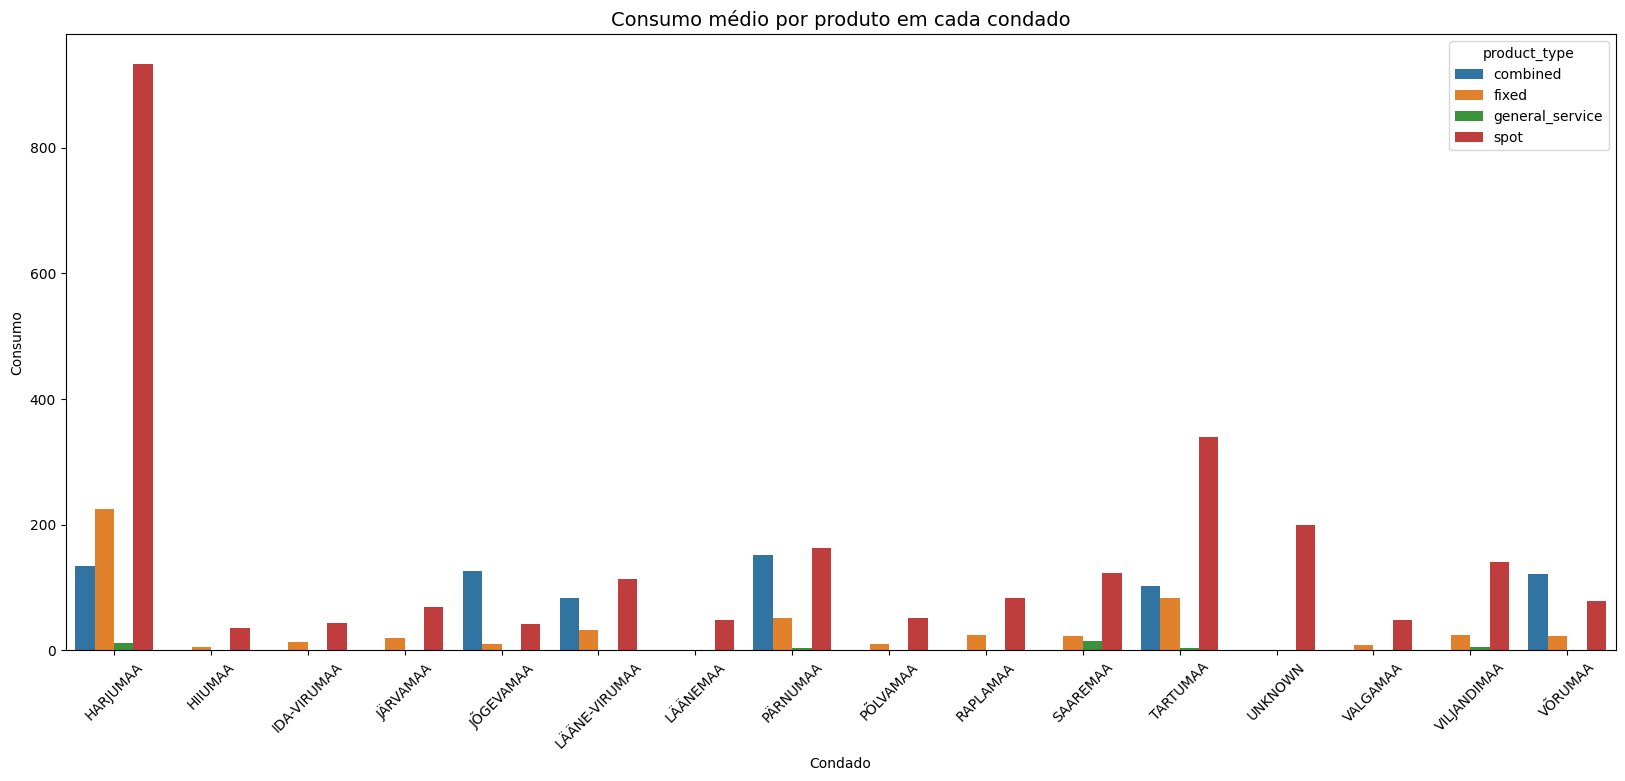

In [24]:
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x='desc_county', y='target', data=hip_1, hue='product_type', ax=ax)

ax.set_title('Consumo médio por produto em cada condado', fontsize=14)
ax.set_xlabel('Condado', fontsize=10)
ax.set_ylabel('Consumo', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

O condado de HARJUMAA possui o maior consumo dentro todos os condados, seguido por TARTUMAA e PÄRNUMAA.

## 3.4 - Correlação entre as variáveis

In [25]:
df3_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2017824 entries, 0 to 2018351
Data columns (total 13 columns):
 #   Column          Dtype         
---  ------          -----         
 0   county          uint8         
 1   is_business     uint8         
 2   product_type    category      
 3   target          float64       
 4   is_consumption  uint8         
 5   datetime        datetime64[ns]
 6   month           uint8         
 7   day             uint8         
 8   weekday         uint8         
 9   hour            uint8         
 10  year            uint16        
 11  week_of_year    uint8         
 12  day_period      category      
dtypes: category(2), datetime64[ns](1), float64(1), uint16(1), uint8(8)
memory usage: 69.3 MB


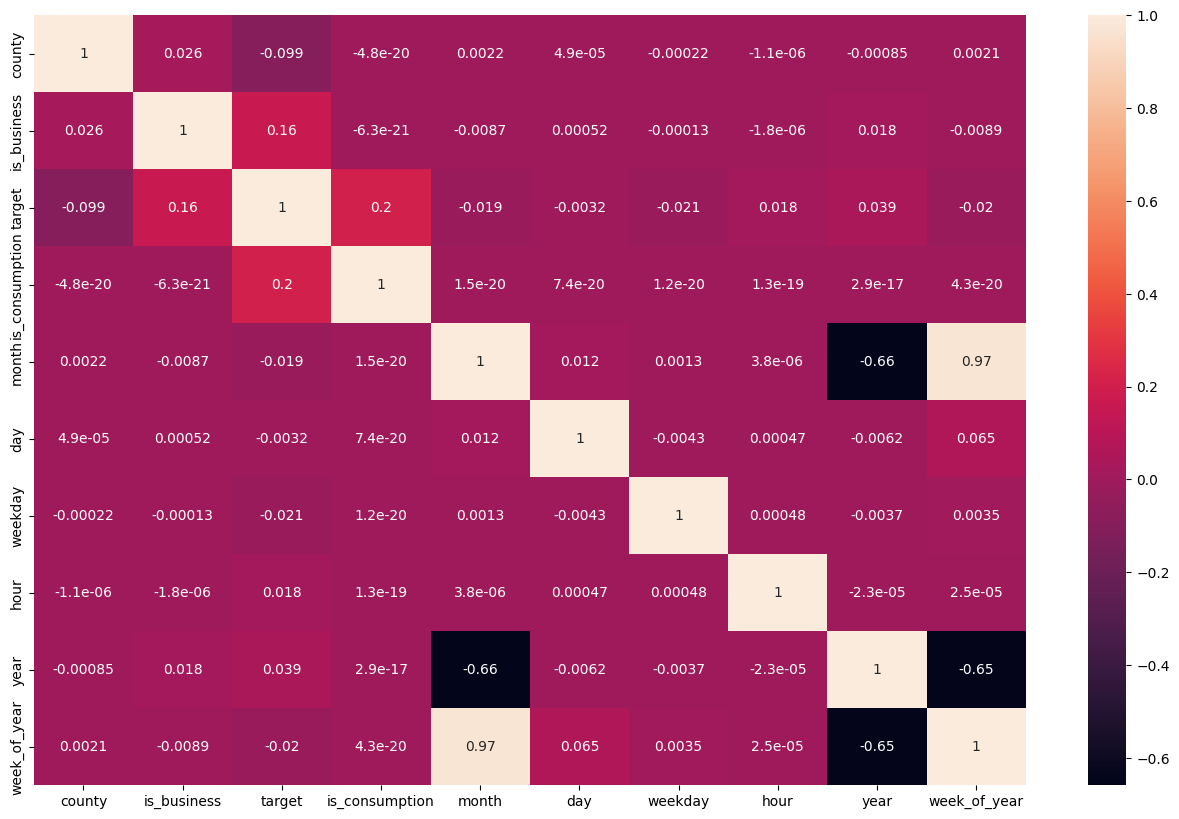

In [26]:
num_attributes = df3_train.select_dtypes(exclude=["category", "datetime64[ns]"])

correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(16,10))
sns.heatmap(correlation, annot=True);

Nenhuma variável possui uma alta correlação com a variável 'target', apenas apresentam correlações as features de data que foram criadas 

In [27]:
cat_attributes = df3_train.select_dtypes(include=["category", "datetime64[ns]"])

In [28]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

product_type        4
datetime        15308
day_period          4
dtype: int64

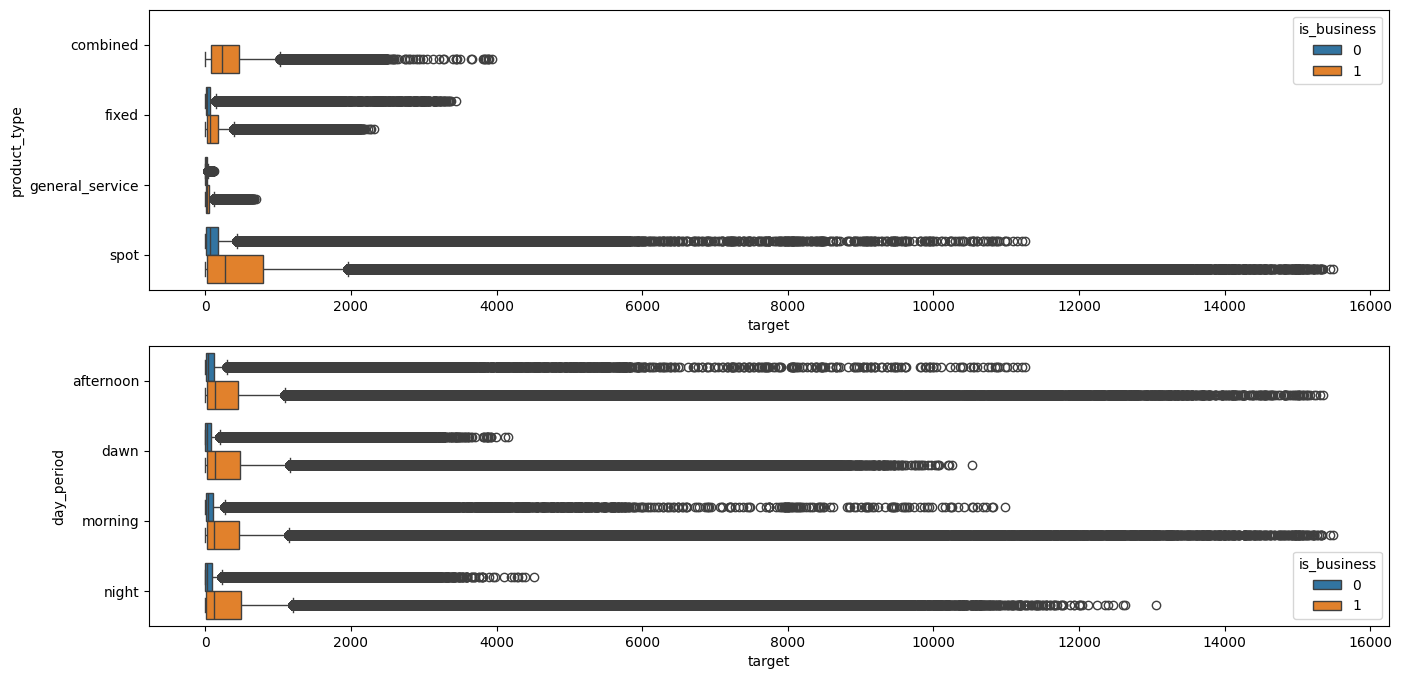

In [33]:
aux1 = df3_train[df3_train['target'] > 0]

plt.figure(figsize = (16,8))

plt.subplot(2, 1, 1)
sns.boxplot( y='product_type', x='target', data=aux1, hue="is_business")

plt.subplot(2, 1, 2)
sns.boxplot( y='day_period', x='target', data=aux1, hue="is_business");

# 4.0 Pre-processing Data

## 4.1 Split Dataframe